In [1]:
cd c:\Users\Rirhc\OneDrive\Desktop\My Folder\CEDT\Year 2\Semester 1.2568\[DSDE]\Project with Git\JekTurnRight_dsde

c:\Users\Rirhc\OneDrive\Desktop\My Folder\CEDT\Year 2\Semester 1.2568\[DSDE]\Project with Git\JekTurnRight_dsde


In [ ]:
# python -m ipykernel install --user --name spark_env --display-name "Python (spark_env)"

In [2]:
import pandas as pd
# import geopandas as gpd
# import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import plotly.express as px
# from src.de.load.loader import DataLoader
# from src.common.dataprep import get_cleaned_data
# from src.common.dataprep import clean_type_columns
# from src.common.dataprep import get_shape_file

ModuleNotFoundError: No module named 'plotly'

In [2]:
#==== Import DS Libraries
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
import branca.colormap as cm 

# Geographic Map Plotting
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

# Display
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display, clear_output

#==== Import DE Components
from src.common.dataprep import get_cleaned_data
from src.common.dataprep import clean_type_columns
from src.common.dataprep import get_shape_file

# Setup Path and Import File

In [14]:
df_path = 'data/raw/bangkok_traffy.csv'
shape_path = 'data/raw/BMA/BMA_ADMIN_SUB_DISTRICT.shp'
check_subdis_path = 'data/raw/subwithdis.csv'

df = get_cleaned_data(df_path, shape_path, check_subdis_path)
shape = get_shape_file(shape_path)

shape['centroid'] = shape.geometry.centroid.to_crs(epsg=4326)
shape['latitude'] = shape['centroid'].y
shape['longitude'] = shape['centroid'].x

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 585005 entries, 19 to 774306
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   ticket_id        585005 non-null  object             
 1   type             585005 non-null  object             
 2   organization     585005 non-null  object             
 3   comment          585005 non-null  object             
 4   coords           585005 non-null  object             
 5   address          585005 non-null  object             
 6   subdistrict      585005 non-null  object             
 7   district         585005 non-null  object             
 8   province         585005 non-null  object             
 9   timestamp        585005 non-null  datetime64[ns, UTC]
 10  state            585005 non-null  object             
 11  count_reopen     585005 non-null  int64              
 12  last_activity    585005 non-null  datetime64[ns, UTC]
 13  yea

# Step 0
Create daily report table, which contain amount of report in each date.

In [4]:
df['date_timestamp'] = df['timestamp'].dt.date
daily_reports = df.groupby('date_timestamp').size().reset_index(name='report_count')
daily_reports.rename(columns={'date_timestamp':'date'}, inplace=True)
display(daily_reports)


date  report_count
0    2022-01-16             2
1    2022-01-17             1
2    2022-01-26             1
3    2022-01-30             1
4    2022-02-01             1
..          ...           ...
979  2024-12-27           537
980  2024-12-28           425
981  2024-12-29           381
982  2024-12-30           460
983  2024-12-31           505

[984 rows x 2 columns]

# Report 1 : Distribution of report
### Report 1.1 : Distribution of report (all year)

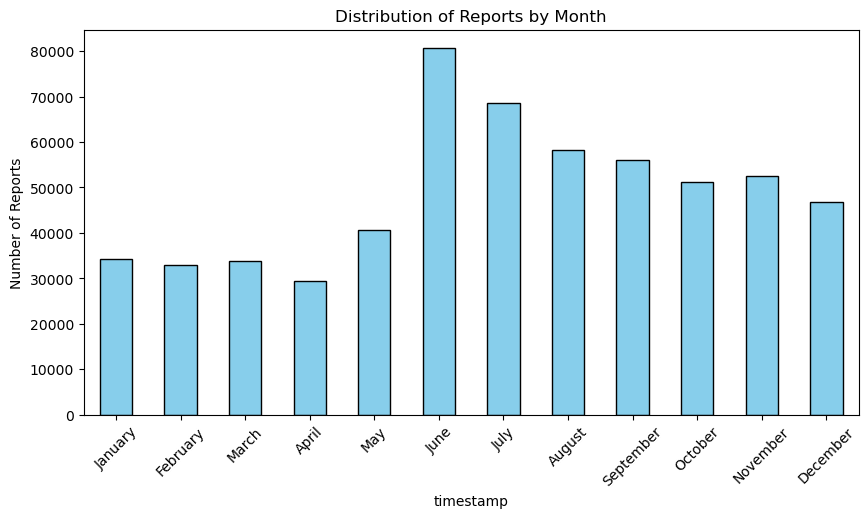

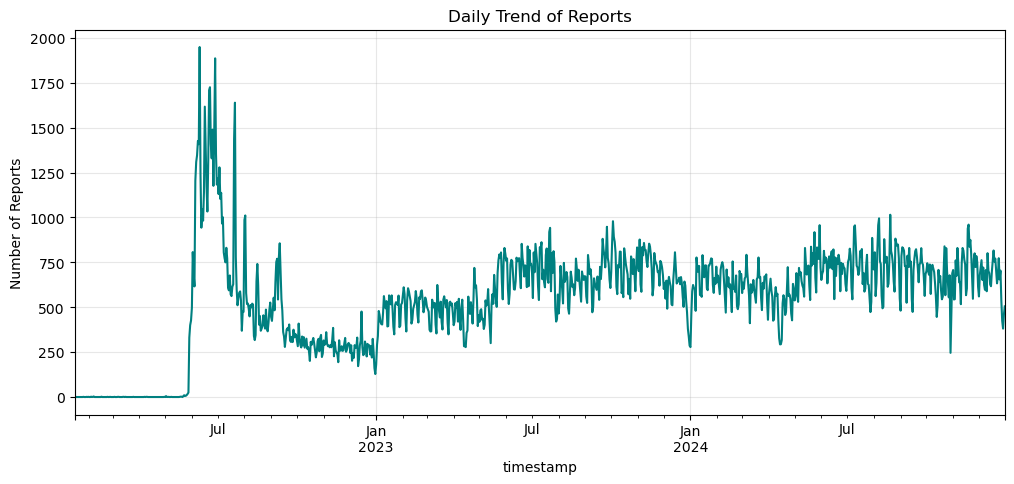

In [5]:
def all_report_distribution(df:pd.DataFrame):
        monthly_counts = df.groupby(df['timestamp'].dt.month_name()).size()

        order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']
        monthly_counts = monthly_counts.reindex(order)

        plt.figure(figsize=(10, 5))
        monthly_counts.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title('Distribution of Reports by Month')
        plt.ylabel('Number of Reports')
        plt.xticks(rotation=45)
        plt.show()

        daily_counts = df.set_index('timestamp').resample('D').size()

        plt.figure(figsize=(12, 5))
        daily_counts.plot(kind='line', color='teal')
        plt.title('Daily Trend of Reports')
        plt.ylabel('Number of Reports')
        plt.grid(True, alpha=0.3)
        plt.show()

all_report_distribution(df)

### Report 1.2 : Distribution of report (in a year)

In [6]:
def all_report_interactive_distribution(df:pd.DataFrame):

    all_years = sorted(df['year_timestamp'].unique())

    def update_charts(selected_years):
        
        filtered_df = df[df['year_timestamp'].isin(selected_years)].copy()
        
        if filtered_df.empty:
            print("No years selected!")
            return

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        monthly_counts = filtered_df.groupby([filtered_df['timestamp'].dt.month, filtered_df['year_timestamp']]).size().unstack()
        monthly_counts.plot(kind='bar', ax=ax1, width=0.8)
        ax1.set_title(f"Monthly Distribution for: {selected_years}")
        ax1.set_xlabel("Month")
        
        daily_counts = filtered_df.set_index('timestamp').resample('D').size()
        daily_counts.plot(kind='line', ax=ax2, color='teal')
        ax2.set_title("Daily Trend")
        
        plt.tight_layout()
        plt.show()

    year_selector = widgets.SelectMultiple(
        options=all_years,
        value=list(all_years),
        description='Years:',
        disabled=False
    )

    interactive_plot = widgets.interactive(update_charts, selected_years=year_selector)
    display(interactive_plot)

all_report_interactive_distribution(df)

interactive(children=(SelectMultiple(description='Years:', index=(0, 1, 2), options=(2022, 2023, 2024), value=…

# Report 2 : Distribution of each tag
### Report 2.1 : Distribution of each tag (all data)

In [7]:
mpl.rc('font', family='Tahoma') 
mpl.rcParams['axes.unicode_minus'] = False

def tag_report_freq(df: pd.DataFrame):
    exploded_df = df.explode('type_list').copy()
    exploded_df['month'] = exploded_df['timestamp'].dt.to_period('M').dt.start_time
    exploded_df['year'] = exploded_df['timestamp'].dt.year

    all_years = sorted(exploded_df['year'].unique())

    all_possible_tags = sorted(exploded_df['type_list'].unique())
    palette = sns.color_palette("tab20", len(all_possible_tags)) 
    color_map = dict(zip(all_possible_tags, palette))

    def plot_tag_trends(years):
        if not years:
            print("Please select at least one year.")
            return

        filtered_data = exploded_df[exploded_df['year'].isin(years)]
        
        if filtered_data.empty:
            print(f"No data found for {years}")
            return

        trend_data = filtered_data.groupby(['month', 'type_list']).size().unstack(fill_value=0)
        
        fig, ax = plt.subplots(figsize=(14, 6))
        
        for tag in trend_data.columns:
            ax.plot(
                trend_data.index, 
                trend_data[tag], 
                marker='o', 
                linewidth=2, 
                label=tag, 
                color=color_map.get(tag, 'black')
            )
        
        year_str = ", ".join(map(str, years))
        ax.set_title(f"แนวโน้มปัญหาปี {year_str}")
        ax.set_xlabel("เดือน") 
        ax.set_ylabel("จำนวนรายงาน")
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    year_widget = widgets.SelectMultiple(
        options=all_years,
        value=[all_years[-1]],
        description='Years:',
        disabled=False
    )

    interact(plot_tag_trends, years=year_widget);

tag_report_freq(df)

C:\Users\Rirhc\AppData\Local\Temp\ipykernel_8088\3161123787.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  exploded_df['month'] = exploded_df['timestamp'].dt.to_period('M').dt.start_time


interactive(children=(SelectMultiple(description='Years:', index=(2,), options=(2022, 2023, 2024), value=(2024…

# Report 3 : Distribution of specific tag
### Report 3.1 : Distribution of tag 'ถนน' (all data)

In [8]:
def tag_distribution(flood_df:pd.DataFrame, tag:str):

    flood_df = flood_df[flood_df['type'].str.contains(tag)]

    monthly_counts = flood_df.groupby(flood_df['timestamp'].dt.month_name()).size()

    order = ['January', 'February', 'March', 'April', 'May', 'June', 
            'July', 'August', 'September', 'October', 'November', 'December']
    monthly_counts = monthly_counts.reindex(order)

    plt.figure(figsize=(10, 5))
    monthly_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Distribution of Reports by Month')
    plt.ylabel('Number of Reports')
    plt.xticks(rotation=45)
    plt.show()

    daily_counts = flood_df.set_index('timestamp').resample('D').size()

    # Plot
    plt.figure(figsize=(12, 5))
    daily_counts.plot(kind='line', color='teal')
    plt.title('Daily Trend of Reports')
    plt.ylabel('Number of Reports')
    plt.grid(True, alpha=0.3)
    plt.show()

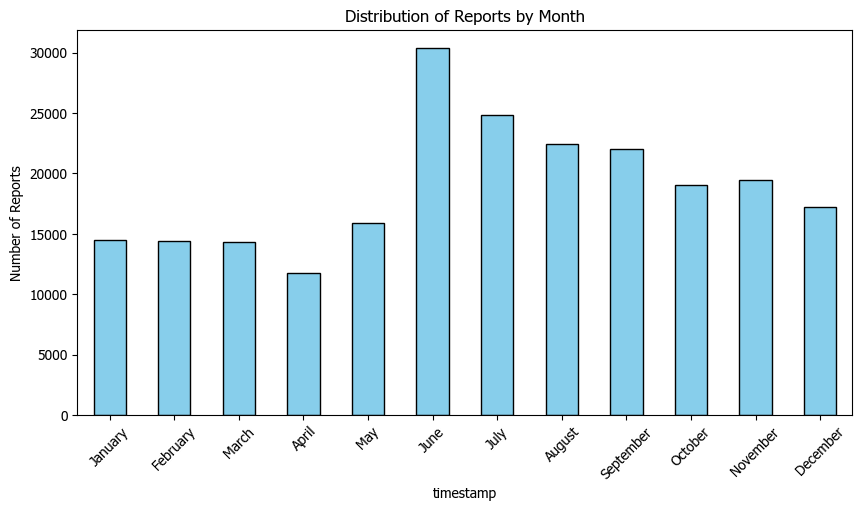

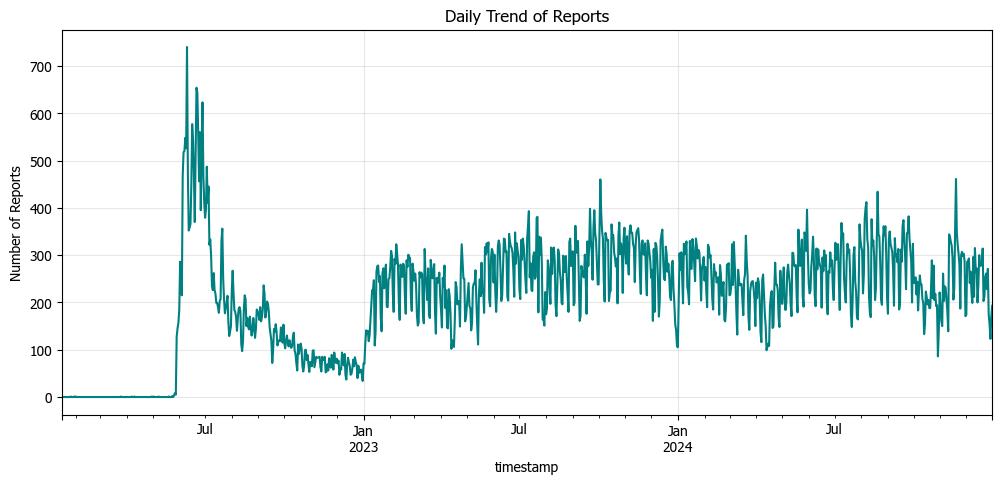

In [9]:
tag_distribution(df, 'ถนน')

### Report 3.2 : Distribution of tag 'น้ำท่วม'

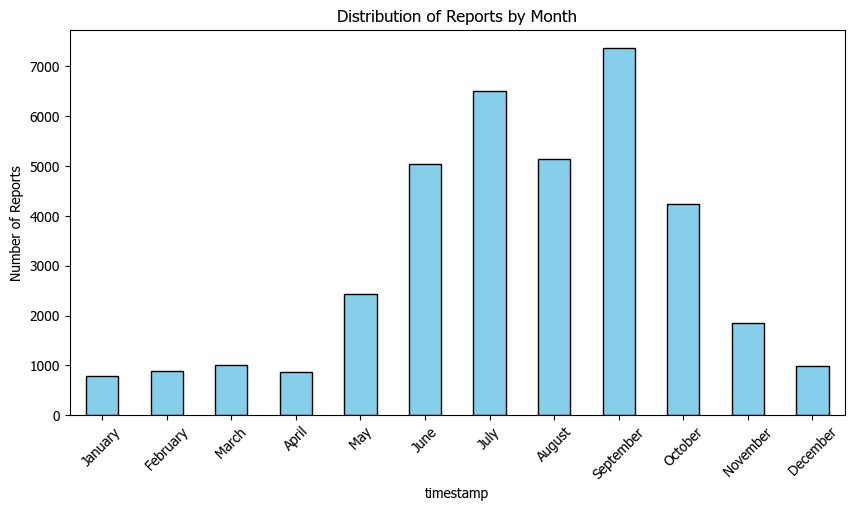

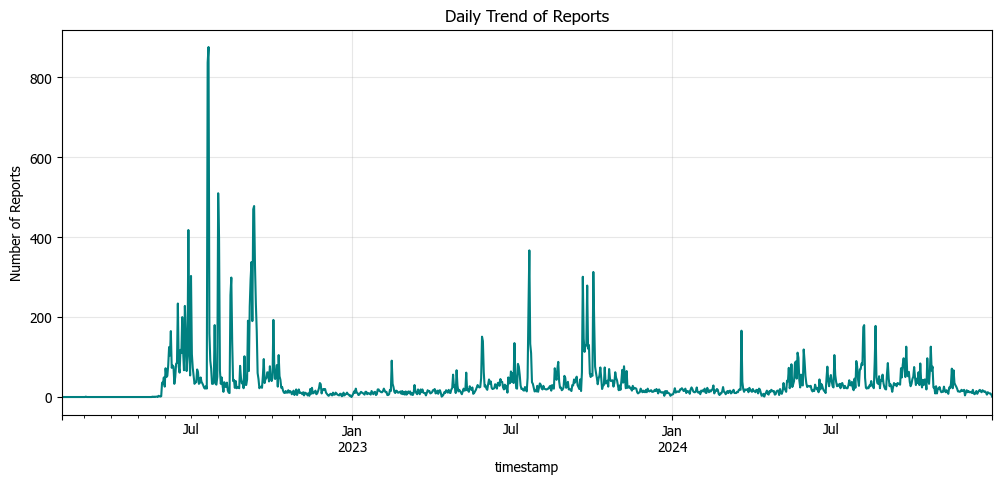

In [10]:
tag_distribution(df, 'น้ำท่วม')

# Report 4 : Distribution of co-occurrence tag with tag 'น้ำท่วม'
### Report 4.1 : Distribution of co-occurrence tag with tag 'น้ำท่วม' (all data)

In [11]:
def co_occurrence_analysis(df:pd.DataFrame, target_tag: str):

    flood_rows = df[df['type_list'].apply(lambda x: target_tag in x if isinstance(x, list) else False)].copy()
    all_co_tags = flood_rows.explode('type_list')
    co_occurrence = all_co_tags[all_co_tags['type_list'] != target_tag]
    tag_counts = co_occurrence['type_list'].value_counts().reset_index()
    tag_counts.columns = ['tag', 'count']

    fig = px.bar(
        tag_counts.head(15),
        x='count', 
        y='tag', 
        orientation='h',
        title=f"Top Tags Co-occurring with '{target_tag}'",
        text='count',
        color='count',
        color_continuous_scale='Blues'
    )

    fig.update_layout(yaxis=dict(autorange="reversed"))
    fig.show()

In [12]:
co_occurrence_analysis(df, 'น้ำท่วม')

# Report 5 : Table number of reports
### Report 5.1 : Table number of reports with tag 'น้ำท่วม' (all data)

In [15]:
def create_complete_daily_summary(df: pd.DataFrame, shape_centers: pd.DataFrame):
    shape_dist_col = 'district'
    shape_sub_col  = 'subdistrict'
    df_dist_col    = 'district'
    df_sub_col     = 'subdistrict'
    start_date = '2022-01-01'
    end_date = '2024-12-31'

    all_dates = pd.DataFrame({'date': pd.date_range(start=start_date, end=end_date, freq='D').date})

    master_locations = shape_centers[[shape_dist_col, shape_sub_col, 'latitude', 'longitude']].copy()

    daily_counts = df.groupby([df_dist_col, df_sub_col, df['timestamp'].dt.date]).size().reset_index(name='number_of_report')
    daily_counts.rename(columns={'timestamp': 'date'}, inplace=True)

    master_locations['_key'] = 1
    all_dates['_key'] = 1
    full_grid = pd.merge(master_locations, all_dates, on='_key').drop('_key', axis=1)

    df_complete = full_grid.merge(
                    daily_counts,
                    left_on=[shape_dist_col, shape_sub_col, 'date'],
                    right_on=[df_dist_col, df_sub_col, 'date'],
                    how='left')
    
    df_complete['number_of_report'] = df_complete['number_of_report'].fillna(0).astype(int)
    df_complete = df_complete[[shape_dist_col, shape_sub_col, 'date', 'number_of_report', 'latitude', 'longitude']]

    df_complete.rename(columns={
        shape_dist_col: 'district', 
        shape_sub_col: 'subdistrict'
    }, inplace=True)

    return df_complete

df_complete = create_complete_daily_summary(df, shape)
display(df_complete.head())

district subdistrict        date  number_of_report   latitude   longitude
0  บางกะปิ     หัวหมาก  2022-01-01                 0  13.755089  100.643706
1  บางกะปิ     หัวหมาก  2022-01-02                 0  13.755089  100.643706
2  บางกะปิ     หัวหมาก  2022-01-03                 0  13.755089  100.643706
3  บางกะปิ     หัวหมาก  2022-01-04                 0  13.755089  100.643706
4  บางกะปิ     หัวหมาก  2022-01-05                 0  13.755089  100.643706

# Report 6 : Heat map of tag 'น้ำท่วม' in each subdistrict
### Report 6.1 : Heat map of tag 'น้ำท่วม' in each subdistrict (accumurate all year)

In [ ]:
def tag_heatmap(df_complete:pd.DataFrame):

    map_data = df_complete[df_complete['number_of_report'] > 0]

    center_lat = map_data['latitude'].mean()
    center_lon = map_data['longitude'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

    heat_data = map_data[['latitude', 'longitude', 'number_of_report']].values.tolist()

    HeatMap(heat_data, radius=15, max_zoom=13).add_to(m)
    m.save('static_heatmap.html')
    display(m)

tag_heatmap(df_complete)

### Report 6.2: Heat map of tag 'น้ำท่วม' in each subdistrict (time-series)

In [30]:
def tag_heatmap_time_series(df_complete: pd.DataFrame):

    df_complete['date'] = pd.to_datetime(df_complete['date'])
    df_complete['month'] = df_complete['date'].dt.to_period('M').dt.start_time
    monthly_df = df_complete.groupby(['latitude', 'longitude', 'month'])['number_of_report'].sum().reset_index()

    time_index = sorted(monthly_df['month'].unique()) # Get all months in order
    data_by_month = []
    time_labels = []

    for m_date in time_index:
        month_data = monthly_df[monthly_df['month'] == m_date]
        month_data = month_data[month_data['number_of_report'] > 0]
        data_by_month.append(month_data[['latitude', 'longitude', 'number_of_report']].values.tolist())
        time_labels.append(m_date.strftime('%Y-%m'))

    center_lat = monthly_df['latitude'].mean()
    center_lon = monthly_df['longitude'].mean()
    m2 = folium.Map(location=[center_lat, center_lon], zoom_start=10)

    HeatMapWithTime(
        data_by_month, 
        index=time_labels,
        radius=25,
        auto_play=True,
        max_opacity=0.6
    ).add_to(m2)

    m2.save('monthly_flood_heatmap.html')
    display(m2)

tag_heatmap_time_series(df_complete)

# Report 7 : Distribution of time-range to solve 'น้ำท่วม' problem
### Report 7.1 : Distribution of time-range to solve 'น้ำท่วม' problem

In [ ]:
selected_cols = ['district', 'subdistrict', 'province', 'timestamp', 'last_activity', 'latitude', 'longitude']

# Get type 'น้ำท่วม'
solve_df = df[df['type'].str.contains('น้ำท่วม')]

# Get only 'เสร็จสิ้น' type
solve_df = solve_df[solve_df['state'] == 'เสร็จสิ้น']

# Get only selected columns
solve_df = solve_df[selected_cols]

# Convert date columns to date format
solve_df['timestamp'] = pd.to_datetime(solve_df['timestamp']).dt.normalize()
solve_df['last_activity'] = pd.to_datetime(solve_df['last_activity']).dt.normalize()

# Create new time-range cols
solve_df['range'] = solve_df['last_activity'] - solve_df['timestamp']

solve_df.head(10)

district subdistrict       province                 timestamp  \
41       สาทร  ทุ่งมหาเมฆ  กรุงเทพมหานคร 2022-02-04 00:00:00+00:00   
74   ตลิ่งชัน    บางระมาด  กรุงเทพมหานคร 2022-03-03 00:00:00+00:00   
151  ลาดพร้าว    จรเข้บัว  กรุงเทพมหานคร 2022-05-18 00:00:00+00:00   
161  ลาดพร้าว    ลาดพร้าว  กรุงเทพมหานคร 2022-05-20 00:00:00+00:00   
168    บางเขน  อนุสาวรีย์  กรุงเทพมหานคร 2022-05-22 00:00:00+00:00   
187  ลาดพร้าว    ลาดพร้าว  กรุงเทพมหานคร 2022-05-23 00:00:00+00:00   
204  ลาดพร้าว    ลาดพร้าว  กรุงเทพมหานคร 2022-05-25 00:00:00+00:00   
208  ลาดพร้าว    ลาดพร้าว  กรุงเทพมหานคร 2022-05-25 00:00:00+00:00   
209  ลาดพร้าว    ลาดพร้าว  กรุงเทพมหานคร 2022-05-25 00:00:00+00:00   
226   บึงกุ่ม   นวลจันทร์  กรุงเทพมหานคร 2022-05-26 00:00:00+00:00   

                last_activity  latitude  longitude    range  
41  2022-11-13 00:00:00+00:00  13.71880  100.53882 282 days  
74  2024-03-08 00:00:00+00:00  13.76444  100.42054 736 days  
151 2024-03-05 00:00:00+00:00  13.84060  100.61164 657 days  
161 2024-03-05 00:00:00+00:00  13.81385  100.59519 655 days  
168 2024-03-05 00:00:00+00:00  13.86314  100.61380 653 days  
187 2024-03-06 00:00:00+00:00  13.81616  100.60008 653 days  
204 2022-05-25 00:00:00+00:00  13.80358  100.60760   0 days  
208 2022-05-25 00:00:00+00:00  13.80620  100.60811   0 days  
209 2022-05-25 00:00:00+00:00  13.80869  100.60784   0 days  
226 2022-06-15 00:00:00+00:00  13.83921  100.64622  20 days

In [ ]:
solve_df['range'].describe()

count                          33188
mean      50 days 23:00:56.839821622
std      107 days 07:03:50.381751020
min                  0 days 00:00:00
25%                  2 days 00:00:00
50%                  7 days 00:00:00
75%                 42 days 00:00:00
max                950 days 00:00:00
Name: range, dtype: object

C:\Users\Rirhc\AppData\Local\Temp\ipykernel_8088\2684688917.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




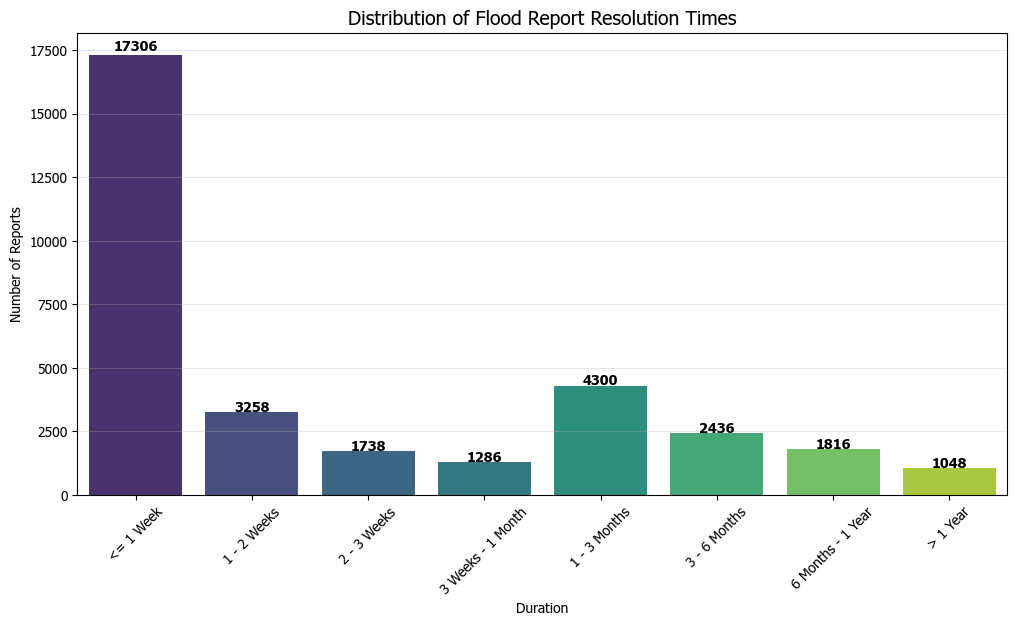

In [34]:
def tag_time_solve_distribution(solve_df:pd.DataFrame):

    solve_df['days_taken'] = solve_df['range'].dt.days

    bins = [0, 7, 14, 21, 30, 90, 180, 365, float('inf')]
    labels = [
        '<= 1 Week', 
        '1 - 2 Weeks', 
        '2 - 3 Weeks', 
        '3 Weeks - 1 Month', 
        '1 - 3 Months', 
        '3 - 6 Months', 
        '6 Months - 1 Year', 
        '> 1 Year'
    ]

    solve_df['duration_group'] = pd.cut(
        solve_df['days_taken'], 
        bins=bins, 
        labels=labels, 
        right=True,
        include_lowest=True
    )

    dist_counts = solve_df['duration_group'].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=dist_counts.index, y=dist_counts.values, palette='viridis')

    for i, v in enumerate(dist_counts.values):
        ax.text(i, v + (v*0.01), str(v), ha='center', fontweight='bold')

    plt.title('Distribution of Flood Report Resolution Times', fontsize=14)
    plt.ylabel('Number of Reports')
    plt.xlabel('Duration')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

tag_time_solve_distribution(solve_df)